# Table of Contents
 <p>

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import lal
import lalsimulation as lalsim
import numpy as np

In [2]:
def convert_from_cartesian_to_polar(x, y, z):
    """
    function to convert from 3d cartesian components to polar angles and vector magnitude.
    https://en.wikipedia.org/wiki/Spherical_coordinate_system#Cartesian_coordinates
    """
    mag = np.sqrt(x * x + y * y + z * z)
    if (np.abs(mag - 0.) < 1e-9):
        polar = 0.
        azimuthal = 0.
    else:
        polar = np.arccos(z / mag)
        azimuthal = np.arctan2(y, x)
    return mag, polar, azimuthal

In [3]:
def same_as_init_PhenomPv3HM_Storage(
    m1_SI,
    m2_SI,
    f_ref,
    phiRef,
    inclination,
    chi1x,
    chi1y,
    chi1z,
    chi2x,
    chi2y,
    chi2z
):
    assert m1_SI >= m2_SI, "m1 needs to be the primary"

    #rotate from LAL to PhenomP frame
    chi1_l, chi2_l, chip, thetaJN, alpha0, phi_aligned, zeta_polariz = \
        lalsim.SimIMRPhenomPCalculateModelParametersFromSourceFrame(
            m1_SI, m2_SI, f_ref, phiRef, inclination,
            chi1x, chi1y, chi1z,
            chi2x, chi2y, chi2z,
            lalsim.IMRPhenomPv3_V)


    # chi1, theta1, phi1 = convert_from_cartesian_to_polar(chi1x, chi1y, chi1z)
    # costheta1 = np.cos(theta1)
    # chi2, theta2, phi2 = convert_from_cartesian_to_polar(chi2x, chi2y, chi2z)
    # costheta2 = np.cos(theta2)

    # f_ref_Orb_Hz = 0.5 * f_ref

    # orb_ref_freq = lal.CreateREAL8Sequence(1)
    # orb_ref_freq.data[0] = f_ref_Orb_Hz

    # ref_phiz_of_f = lal.CreateREAL8Sequence(1)  # phiz or alpha
    # ref_zeta_of_f = lal.CreateREAL8Sequence(1)  # zeta or epsilon
    # ref_costhetaL_of_f = lal.CreateREAL8Sequence(1)  # costhetaL or beta

    # ExpansionOrder = 5
    # costhetaL = 1.
    # phiL = 0.

    # lalsim.ComputeAngles3PN(ref_phiz_of_f, ref_zeta_of_f, ref_costhetaL_of_f,
    #                         orb_ref_freq,
    #                         m1_SI, m2_SI,
    #                         costhetaL, phiL,
    #                         costheta1, phi1, chi1,
    #                         costheta2, phi2, chi2,
    #                         f_ref, ExpansionOrder)
    # alphaRef = ref_phiz_of_f.data[0]
    # epsilonRef = ref_zeta_of_f.data[0]
    # betaRef = np.arccos(ref_costhetaL_of_f.data[0])

    # return alphaRef, epsilonRef, thetaJN, alpha0, phi_aligned, zeta_polariz
    return 0,0, thetaJN, alpha0, phi_aligned, zeta_polariz

In [4]:
def run_type_2(m1,m2,chi1x,chi1y,chi1z,chi2x,chi2y,chi2z,phiref,f_ref,df,flow,fhigh,inclination,distance, modes):

    x = np.arange(flow, fhigh, df)
    freqs = lal.CreateREAL8Sequence(len(x))
    freqs.data = x

    f_ref = flow

    m1_SI=m1 * lal.MSUN_SI
    m2_SI=m2 * lal.MSUN_SI
    deltaF=df

    amp0 = lalsim.SimPhenomUtilsFDamp0((m1_SI + m2_SI) / lal.MSUN_SI, distance)


    params = lal.CreateDict()
    ma=lalsim.SimInspiralCreateModeArray()

    for l,m in modes:
        lalsim.SimInspiralModeArrayActivateMode(ma, l, m)

    lalsim.SimInspiralWaveformParamsInsertModeArray(params, ma)

    phm_params = dict(
        freqs=freqs,
        m1_SI=m1_SI,
        m2_SI=m2_SI,
        chi1x=chi1x,
        chi1y=chi1y,
        chi1z=chi1z,
        chi2x=chi2x,
        chi2y=chi2y,
        chi2z=chi2z,
        phiRef=phiref,
        deltaF=deltaF,
        f_ref=f_ref,
        extraParams=params
    )

    alphaRef, epsilonRef, thetaJN, alpha0, phi_aligned, zeta_polariz = \
        same_as_init_PhenomPv3HM_Storage(
            m1_SI,
            m2_SI,
            f_ref,
            phiref,
            inclination,
            chi1x,
            chi1y,
            chi1z,
            chi2x,
            chi2y,
            chi2z
        )

    hlms = lalsim.SimIMRPhenomHMGethlmModes(**phm_params)

    # h22 = lalsim.SphHarmFrequencySeriesGetMode(hlms, 2, 2)
    # f22 = np.arange( h22.data.length ) * h22.deltaF

    ModeArray = lalsim.SimInspiralWaveformParamsLookupModeArray(params)


    Mtot_Msun = (m1_SI + m2_SI) / lal.MSUN_SI
    Msec = Mtot_Msun * lal.MTSUN_SI
    twopi_Msec = lal.TWOPI * Msec

    # compute precession angles over all frequencies
    # only need to do this once.

    phiz_of_f = lal.CreateREAL8Sequence(len(freqs.data))  # phiz or alpha
    zeta_of_f = lal.CreateREAL8Sequence(len(freqs.data))  # zeta or epsilon
    costhetaL_of_f = lal.CreateREAL8Sequence(len(freqs.data))  # costhetaL or beta

    ExpansionOrder = 5
    costhetaL = 1.
    phiL = 0.

    chi1, theta1, phi1 = convert_from_cartesian_to_polar(chi1x, chi1y, chi1z)
    costheta1 = np.cos(theta1)
    chi2, theta2, phi2 = convert_from_cartesian_to_polar(chi2x, chi2y, chi2z)
    costheta2 = np.cos(theta2)

    hplus = np.zeros(len(freqs.data), dtype=np.complex64)
    hcross = np.zeros(len(freqs.data), dtype=np.complex64)

    for ell in range(2,5):
        # loop over ell = [2,3,4]
        for mprime in range(ell+1):
            # mprime is the index for the modes in the non-precessing model
            ms = lalsim.SimInspiralModeArrayIsModeActive(ModeArray, ell, mprime)
            if ms != 1:
                continue
            print("ell = {}, mprime = {}".format(ell, mprime))
            print("mode state = {}".format(ms))
            # get non-precessing mode
            hlm_np = lalsim.SphHarmFrequencySeriesGetMode(hlms, ell, mprime)
            # flm_array = np.arange( hlm_np.data.length ) * hlm_np.deltaF

            # now we loop over all m-modes in the current ell-mode
            # and "do the twist"

            orb_freqs = lal.CreateREAL8Sequence(len(freqs.data))
            orb_freqs.data = freqs.data / mprime

            lalsim.ComputeAngles3PN(phiz_of_f, zeta_of_f, costhetaL_of_f,
                                    orb_freqs,
                                    m1_SI, m2_SI,
                                    costhetaL, phiL,
                                    costheta1, phi1, chi1,
                                    costheta2, phi2, chi2,
                                    f_ref, ExpansionOrder)

            for mm in range(-ell, ell+1):
                print("-----> working mm = {}".format(mm))

                # get Ylms
                Y = lal.SpinWeightedSphericalHarmonic(thetaJN, 0, -2, ell, mm)
                # NOTE: we use phi=0 in Ylms so they are REAL numbers
                # and the next line is pointless!
                Yconj = np.conj(Y)

                # loop over frequencies
                # for i, fHz in enumerate(flm_array):
                for i, fHz in enumerate(freqs.data):

                    alpha = phiz_of_f.data[i] - alpha0
                    epsilon = zeta_of_f.data[i]
                    beta = np.arccos(costhetaL_of_f.data[i])

                    w1 = np.exp(1.j * mm * alpha)
                    w2 = lal.WignerdMatrix(ell, mprime, mm, -beta)
                    w3 = np.exp(-mprime * 1.j * epsilon)
                    WigD = w1 * w2 * w3

                    w2m = lal.WignerdMatrix(ell, -mprime, mm, -beta)
                    w4 = np.exp(-mprime * -1.j * epsilon)
                    WigDmConj = np.conj(w1 * w2m * w4)

                    hlm_np_i = hlm_np.data.data[i]

                    Term1 = Y * WigD
                    Term2 = (-1)**(ell)  * Yconj * WigDmConj

                    yy = 0.5 * amp0 * hlm_np_i

                    h1 = yy * (Term1 + Term2)
                    h2 = -1.j * yy * (Term1 - Term2)

                    hplus[i] += h1
                    hcross[i] += h2

    cos2zeta = np.cos(2. * zeta_polariz)
    sin2zeta = np.sin(2. * zeta_polariz)

    for i in range(len(hplus)):
        PhPpolp = hplus[i]
        PhPpolc = hcross[i]
        hplus[i] = PhPpolp * cos2zeta + PhPpolc * sin2zeta
        hcross[i] = PhPpolc * cos2zeta - PhPpolp * sin2zeta

    return hplus, hcross, freqs.data

In [5]:
def run_type_3_pv3(m1,m2,chi1x,chi1y,chi1z,chi2x,chi2y,chi2z,phiref,f_ref,df,flow,fhigh,inclination,distance, modes):

    print("hardcoding modes to 22 mode")
    modes=[(2,2)]

    x = np.arange(flow, fhigh, df)
    freqs = lal.CreateREAL8Sequence(len(x))
    freqs.data = x

    f_ref = flow

    m1_SI=m1 * lal.MSUN_SI
    m2_SI=m2 * lal.MSUN_SI
    deltaF=df

    amp0 = lalsim.SimPhenomUtilsFDamp0((m1_SI + m2_SI) / lal.MSUN_SI, distance)


    params = lal.CreateDict()
    ma=lalsim.SimInspiralCreateModeArray()
    lalsim.SimInspiralModeArrayActivateMode(ma, 2, 2)
    lalsim.SimInspiralWaveformParamsInsertModeArray(params, ma)

    phm_params = dict(
        freqs=freqs,
        m1_SI=m1_SI,
        m2_SI=m2_SI,
        chi1x=chi1x,
        chi1y=chi1y,
        chi1z=chi1z,
        chi2x=chi2x,
        chi2y=chi2y,
        chi2z=chi2z,
        phiRef=phiref,
        deltaF=deltaF,
        f_ref=f_ref,
        extraParams=params
    )

    alphaRef, epsilonRef, thetaJN, alpha0, phi_aligned, zeta_polariz = \
        same_as_init_PhenomPv3HM_Storage(
            m1_SI,
            m2_SI,
            f_ref,
            phiref,
            inclination,
            chi1x,
            chi1y,
            chi1z,
            chi2x,
            chi2y,
            chi2z
        )

    hlms = lalsim.SimIMRPhenomHMGethlmModes(**phm_params)

    # h22 = lalsim.SphHarmFrequencySeriesGetMode(hlms, 2, 2)
    # f22 = np.arange( h22.data.length ) * h22.deltaF

    ModeArray = lalsim.SimInspiralWaveformParamsLookupModeArray(params)


    Mtot_Msun = (m1_SI + m2_SI) / lal.MSUN_SI
    Msec = Mtot_Msun * lal.MTSUN_SI
    twopi_Msec = lal.TWOPI * Msec

    # compute precession angles over all frequencies
    # only need to do this once.

    phiz_of_f = lal.CreateREAL8Sequence(len(freqs.data))  # phiz or alpha
    zeta_of_f = lal.CreateREAL8Sequence(len(freqs.data))  # zeta or epsilon
    costhetaL_of_f = lal.CreateREAL8Sequence(len(freqs.data))  # costhetaL or beta

    ExpansionOrder = 5
    costhetaL = 1.
    phiL = 0.

    chi1, theta1, phi1 = convert_from_cartesian_to_polar(chi1x, chi1y, chi1z)
    costheta1 = np.cos(theta1)
    chi2, theta2, phi2 = convert_from_cartesian_to_polar(chi2x, chi2y, chi2z)
    costheta2 = np.cos(theta2)

    hplus = np.zeros(len(freqs.data), dtype=np.complex64)
    hcross = np.zeros(len(freqs.data), dtype=np.complex64)

    ell=2
    mprime = 2 # mprime is the index for the modes in the non-precessing model
    h22_np = lalsim.SphHarmFrequencySeriesGetMode(hlms, ell, mprime)

    # now we loop over all m-modes in the current ell-mode
    # and "do the twist"

    orb_freqs = lal.CreateREAL8Sequence(len(freqs.data))
    orb_freqs.data = freqs.data / mprime

    lalsim.ComputeAngles3PN(phiz_of_f, zeta_of_f, costhetaL_of_f,
                            orb_freqs,
                            m1_SI, m2_SI,
                            costhetaL, phiL,
                            costheta1, phi1, chi1,
                            costheta2, phi2, chi2,
                            f_ref, ExpansionOrder)

    Y2m2 = lal.SpinWeightedSphericalHarmonic(thetaJN, 0., -2, 2, -2)
    Y2m1 = lal.SpinWeightedSphericalHarmonic(thetaJN, 0., -2, 2, -1)
    Y20  = lal.SpinWeightedSphericalHarmonic(thetaJN, 0., -2, 2,  0)
    Y21  = lal.SpinWeightedSphericalHarmonic(thetaJN, 0., -2, 2,  1)
    Y22  = lal.SpinWeightedSphericalHarmonic(thetaJN, 0., -2, 2,  2)

    Y2mA = [Y2m2, Y2m1, Y20, Y21, Y22]

    sqrt_6 = np.sqrt(6.)

    for i, fHz in enumerate(freqs.data):

        alpha = phiz_of_f.data[i] - alpha0
        epsilon = zeta_of_f.data[i]
        beta = np.arccos(costhetaL_of_f.data[i])

        # REAL8 cBetah, sBetah; /* cos(beta/2), sin(beta/2) */
        cBetah = np.cos(beta/2.0)
        sBetah = np.sin(beta/2.0)

        cBetah2 = cBetah*cBetah
        cBetah3 = cBetah2*cBetah
        cBetah4 = cBetah3*cBetah
        sBetah2 = sBetah*sBetah
        sBetah3 = sBetah2*sBetah
        sBetah4 = sBetah3*sBetah

        d2   = [sBetah4, 2*cBetah*sBetah3, sqrt_6*sBetah2*cBetah2, 2*cBetah3*sBetah, cBetah4]
        #  /* Exploit symmetry d^2_{-2,-m} = (-1)^m d^2_{2,m} */
        dm2  = [d2[4], -d2[3], d2[2], -d2[1], d2[0]]

        hp_sum = 0
        hc_sum = 0

        # /* Sum up contributions to \tilde h+ and \tilde hx */
        # /* Precompute powers of e^{i m alpha} */
        cexp_i_alpha = np.cos(alpha) + 1.j*np.sin(alpha) #//cexp(+I*alpha)
        cexp_2i_alpha = cexp_i_alpha*cexp_i_alpha
        cexp_mi_alpha = 1.0/cexp_i_alpha
        cexp_m2i_alpha = cexp_mi_alpha*cexp_mi_alpha
        cexp_im_alpha = [cexp_m2i_alpha, cexp_mi_alpha, 1.0, cexp_i_alpha, cexp_2i_alpha]


        for m in [-2, -1, 0, 1, 2]:
            # /*  = cexp(-I*m*alpha) * dm2[m+2] *      Y2mA[m+2] */
            # /*  = cexp(+I*m*alpha) * d2[m+2]  * conj(Y2mA[m+2]) */
            T2m   = cexp_im_alpha[-m+2] * dm2[m+2] *      Y2mA[m+2]
            Tm2m  = cexp_im_alpha[m+2]  * d2[m+2]  * np.conj(Y2mA[m+2])
            hp_sum +=     T2m + Tm2m
            hc_sum += +1.j*(T2m - Tm2m)

        h22_np_i = h22_np.data.data[i]
        #//cexp(-2*I*epsilon) * hP / 2.0
        eps_phase_hP = (np.cos(2*epsilon) - 1.j*np.sin(2*epsilon)) *h22_np_i /2.0
        hplus[i] = eps_phase_hP * hp_sum * amp0
        hcross[i] = eps_phase_hP * hc_sum * amp0

    cos2zeta = np.cos(2. * zeta_polariz)
    sin2zeta = np.sin(2. * zeta_polariz)

    for i in range(len(hplus)):
        PhPpolp = hplus[i]
        PhPpolc = hcross[i]
        hplus[i] = PhPpolp * cos2zeta + PhPpolc * sin2zeta
        hcross[i] = PhPpolc * cos2zeta - PhPpolp * sin2zeta

    return hplus, hcross, freqs.data

In [728]:
def BOYLE_run_type_2(m1,m2,chi1x,chi1y,chi1z,chi2x,chi2y,chi2z,phiref,f_ref,df,flow,fhigh,inclination,distance, modes):
    """
    trying to implement the efficient calculation as described
    in arxiv:1409.4431
    """

    x = np.arange(flow, fhigh, df)
    freqs = lal.CreateREAL8Sequence(len(x))
    freqs.data = x

    f_ref = flow

    m1_SI=m1 * lal.MSUN_SI
    m2_SI=m2 * lal.MSUN_SI
    deltaF=df

    amp0 = lalsim.SimPhenomUtilsFDamp0((m1_SI + m2_SI) / lal.MSUN_SI, distance)


    params = lal.CreateDict()
    ma=lalsim.SimInspiralCreateModeArray()

    for l,m in modes:
        lalsim.SimInspiralModeArrayActivateMode(ma, l, m)

    lalsim.SimInspiralWaveformParamsInsertModeArray(params, ma)

    phm_params = dict(
        freqs=freqs,
        m1_SI=m1_SI,
        m2_SI=m2_SI,
        chi1x=chi1x,
        chi1y=chi1y,
        chi1z=chi1z,
        chi2x=chi2x,
        chi2y=chi2y,
        chi2z=chi2z,
        phiRef=phiref,
        deltaF=deltaF,
        f_ref=f_ref,
        extraParams=params
    )

    alphaRef, epsilonRef, thetaJN, alpha0, phi_aligned, zeta_polariz = \
        same_as_init_PhenomPv3HM_Storage(
            m1_SI,
            m2_SI,
            f_ref,
            phiref,
            inclination,
            chi1x,
            chi1y,
            chi1z,
            chi2x,
            chi2y,
            chi2z
        )

    hlms = lalsim.SimIMRPhenomHMGethlmModes(**phm_params)

    # h22 = lalsim.SphHarmFrequencySeriesGetMode(hlms, 2, 2)
    # f22 = np.arange( h22.data.length ) * h22.deltaF

    ModeArray = lalsim.SimInspiralWaveformParamsLookupModeArray(params)


    Mtot_Msun = (m1_SI + m2_SI) / lal.MSUN_SI
    Msec = Mtot_Msun * lal.MTSUN_SI
    twopi_Msec = lal.TWOPI * Msec

    # compute precession angles over all frequencies
    # only need to do this once.

    phiz_of_f = lal.CreateREAL8Sequence(len(freqs.data))  # phiz or alpha
    zeta_of_f = lal.CreateREAL8Sequence(len(freqs.data))  # zeta or epsilon
    costhetaL_of_f = lal.CreateREAL8Sequence(len(freqs.data))  # costhetaL or beta

    ExpansionOrder = 5
    costhetaL = 1.
    phiL = 0.

    chi1, theta1, phi1 = convert_from_cartesian_to_polar(chi1x, chi1y, chi1z)
    costheta1 = np.cos(theta1)
    chi2, theta2, phi2 = convert_from_cartesian_to_polar(chi2x, chi2y, chi2z)
    costheta2 = np.cos(theta2)

    hplus = np.zeros(len(freqs.data), dtype=np.complex64)
    hcross = np.zeros(len(freqs.data), dtype=np.complex64)

    for ell in range(2,5):
        # loop over ell = [2,3,4]
        for mprime in range(ell+1):
            # mprime is the index for the modes in the non-precessing model
            ms = lalsim.SimInspiralModeArrayIsModeActive(ModeArray, ell, mprime)
            if ms != 1:
                continue
            print("ell = {}, mprime = {}".format(ell, mprime))
            print("mode state = {}".format(ms))
            # get non-precessing mode
            hlm_np = lalsim.SphHarmFrequencySeriesGetMode(hlms, ell, mprime)
            # flm_array = np.arange( hlm_np.data.length ) * hlm_np.deltaF

            # now we loop over all m-modes in the current ell-mode
            # and "do the twist"

            orb_freqs = lal.CreateREAL8Sequence(len(freqs.data))
            orb_freqs.data = freqs.data / mprime

            lalsim.ComputeAngles3PN(phiz_of_f, zeta_of_f, costhetaL_of_f,
                                    orb_freqs,
                                    m1_SI, m2_SI,
                                    costhetaL, phiL,
                                    costheta1, phi1, chi1,
                                    costheta2, phi2, chi2,
                                    f_ref, ExpansionOrder)

            for i, fHz in enumerate(freqs.data):
                alpha = phiz_of_f.data[i] - alpha0
                epsilon = zeta_of_f.data[i]
                beta = np.arccos(costhetaL_of_f.data[i])
                
                Ylm = lal.SpinWeightedSphericalHarmonic(thetaJN - beta, alpha, -2, ell, mprime)
                YlmConj = np.conj(lal.SpinWeightedSphericalHarmonic(thetaJN - beta, alpha, -2, ell, -mprime))    
                ep_exp = np.exp(-1.j * mprime * epsilon)

# these need to be thetaJN - beta
#                 The following lines work in the non-precessing case.
# NOTE: in the 'ep_exp' you need 'mprime' not just '2' as in MB paper.
# this also needs to be a minus sign
#                 Ylm = lal.SpinWeightedSphericalHarmonic(thetaJN, 0, -2, ell, mprime)
#                 YlmConj = np.conj(lal.SpinWeightedSphericalHarmonic(thetaJN, 0, -2, ell, -mprime))
#                 ep_exp = np.exp(-1.j * mprime * 0.)

                
                minus1l = (-1)**(ell)
                factorp = 0.5 * (Ylm + minus1l * YlmConj)
                factorc = 1.j * 0.5 * (Ylm - minus1l * YlmConj)
                
                hlm_np_i = hlm_np.data.data[i]
                pre = hlm_np_i * ep_exp * amp0
                
                h1 = pre * (factorp)
                h2 = pre * (factorc)
                
                hplus[i] += h1
                hcross[i] += h2

    cos2zeta = np.cos(2. * zeta_polariz)
    sin2zeta = np.sin(2. * zeta_polariz)

    for i in range(len(hplus)):
        PhPpolp = hplus[i]
        PhPpolc = hcross[i]
        hplus[i] = PhPpolp * cos2zeta + PhPpolc * sin2zeta
        hcross[i] = PhPpolc * cos2zeta - PhPpolp * sin2zeta

    return hplus, hcross, freqs.data

In [729]:
# modes=[(2,2),(3,2)]
modes=[(2,2)]
# modes=[(2,2),(2,1)]
# modes=[(2,2),(4,4)]
# modes=[(2,2)]
# modes=[(2,2),(2,1),(3,3),(3,2),(4,4),(4,3)]

default_pars = dict(
    m1=20,m2=10,chi1x=0.3,chi1y=0,chi1z=0,chi2x=0,chi2y=0,chi2z=0,phiref=0,
    f_ref=20,df=0.1,flow=20,fhigh=1024*1.6,inclination=np.pi/3.,
    distance=1e6*lal.PC_SI, modes=modes)

In [730]:
%%time
hpMB, hcMB, fMB = BOYLE_run_type_2(**default_pars)

ell = 2, mprime = 2
mode state = 1
CPU times: user 510 ms, sys: 38.9 ms, total: 549 ms
Wall time: 522 ms


In [731]:
%%time
hp2, hc2, f2 = run_type_2(**default_pars)

ell = 2, mprime = 2
mode state = 1
-----> working mm = -2
-----> working mm = -1
-----> working mm = 0
-----> working mm = 1
-----> working mm = 2
CPU times: user 1.7 s, sys: 104 ms, total: 1.81 s
Wall time: 1.73 s


In [732]:
%%time
hp3, hc3, f3 = run_type_3_pv3(**default_pars)

hardcoding modes to 22 mode
CPU times: user 861 ms, sys: 78.4 ms, total: 939 ms
Wall time: 885 ms


In [733]:
params = lal.CreateDict()
ma=lalsim.SimInspiralCreateModeArray()

for l,m in modes:
    lalsim.SimInspiralModeArrayActivateMode(ma, l, m)

lalsim.SimInspiralWaveformParamsInsertModeArray(params, ma)

0

In [734]:
# PhenomPv3HM
hplal,hclal=lalsim.SimInspiralChooseFDWaveform(
    default_pars['m1']*lal.MSUN_SI,
    default_pars['m2']*lal.MSUN_SI,
    default_pars['chi1x'],default_pars['chi1y'],default_pars['chi1z'],
    default_pars['chi2x'],default_pars['chi2y'],default_pars['chi2z'],
    default_pars['distance'],
    default_pars['inclination'],
    default_pars['phiref'],
    0,
    0,
    0,
    default_pars['df'],
    default_pars['flow'],
    default_pars['fhigh'],
    default_pars['f_ref'],
    params,
    lalsim.IMRPhenomPv3HM
)

f_lal = np.arange(hplal.data.length) * hplal.deltaF

In [735]:
# let's remove the leading order PN frequency scaling to make comparisons easier

In [736]:
# for lal
f_lal_nonzero = f_lal[np.abs(hplal.data.data)>0]
hplal_nonzero = hplal.data.data[np.abs(hplal.data.data)>0]
hclal_nonzero = hclal.data.data[np.abs(hclal.data.data)>0]

f_lal_nonzero_PNscale = np.array([ff**(-7/6.) for ff in f_lal_nonzero])

In [737]:
# for my version
f2_PNscale = np.array([ff**(-7./6) for ff in f2])

In [738]:
# MB version

fMB_PNscale = np.array([ff**(-7./6) for ff in fMB])

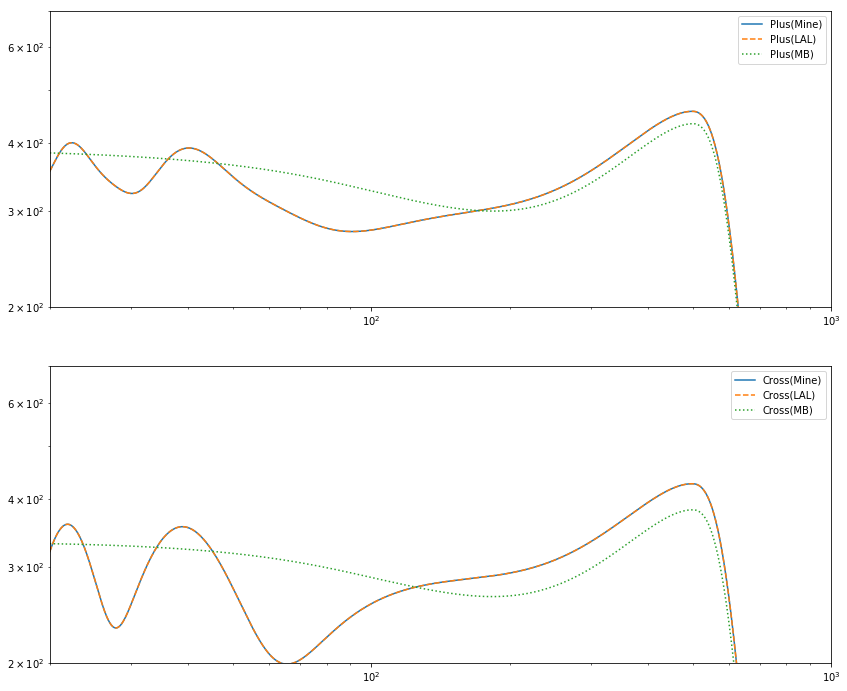

In [739]:
sc=1e21

fig, axes = plt.subplots(2, 1, figsize=(14, 12))

axes[0].plot(f2, np.abs(hp2)/f2_PNscale * sc, label='Plus(Mine)')
axes[0].plot(f_lal_nonzero, np.abs(hplal_nonzero)/f_lal_nonzero_PNscale * sc, label='Plus(LAL)', ls='--')

axes[0].plot(fMB, np.abs(hpMB)/fMB_PNscale * sc, label='Plus(MB)', ls=':')

axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].legend()

axes[1].plot(f2, np.abs(hc2)/f2_PNscale * sc, label='Cross(Mine)')
axes[1].plot(f_lal_nonzero, np.abs(hclal_nonzero)/f_lal_nonzero_PNscale * sc, label='Cross(LAL)', ls='--')

axes[1].plot(fMB, np.abs(hcMB)/fMB_PNscale * sc, label='Cross(MB)',ls=':')

axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].legend()

for ax in axes:
    ax.set_xlim(20, 1000)
    ax.set_ylim(200, 700)

plt.show()

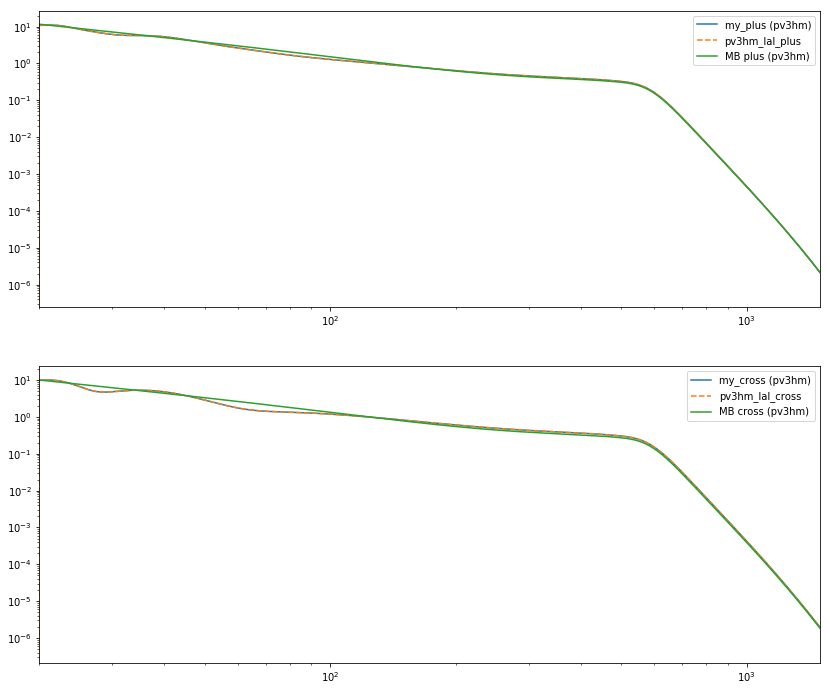

In [740]:
#without f**(-7/6) scaling

sc=1e21

fig, axes = plt.subplots(2, 1, figsize=(14, 12))

axes[0].plot(f2, np.abs(hp2) * sc, ls='-', label='my_plus (pv3hm)')
axes[0].plot(f_lal, np.abs(hplal.data.data) * sc, ls='--', label='pv3hm_lal_plus')

axes[0].plot(fMB, np.abs(hpMB) * sc, ls='-', label='MB plus (pv3hm)')

axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].legend()

axes[1].plot(f2, np.abs(hc2) * sc, ls='-', label='my_cross (pv3hm)')
axes[1].plot(f_lal, np.abs(hclal.data.data) * sc, ls='--', label='pv3hm_lal_cross')

axes[1].plot(fMB, np.abs(hcMB) * sc, ls='-', label='MB cross (pv3hm)')

axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].legend()

for ax in axes:
    ax.set_xlim(20, 1500)
#     ax.set_ylim(1e0, 2e1)

plt.show()